In [2]:
from ultralytics import YOLO
import cv2
from ultralytics.utils.plotting import Annotator  # ultralytics.yolo.utils.plotting is deprecated
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [3]:
model = YOLO('yolov8x.pt').to('mps')

In [144]:
cap = cv2.VideoCapture("/Users/morris/Documents/Git/Hackathon2023/data/long_bieberach.mov")
centers = [] # Array of center positions (x, y)

counter = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    counter+=1
    if counter%5!=0:
        continue

    image = frame

    results = model.predict(frame, verbose=False, conf=0.005, classes=[0])[0].cpu() # Class 0 for Person and Confidence Threshold
    for result in results:
        for box in result.boxes:
            b = box.xyxy[0]  # get box coordinates in (top, left, bottom, right) format
            x0, y0, x1, y1 = b
            x, y, w, h = x0, y0, x1-x0, y1-y0
            center = (int(x + w/2), int(y1))#, int(y + h/2)) # y1 für die Position der Füße
            centers.append(center)

cap.release()
cv2.destroyAllWindows()

In [147]:
densities = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
for center in tqdm(centers):
    size = (10, 10)#(int(w/2 * 0.04), int(h/2 * 0.04))
    angle = 0
    startAngle = 0
    endAngle = 360
    density = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    cv2.ellipse(density, center, size, angle, startAngle, endAngle, (1, 1), -1)
    density = cv2.GaussianBlur(density, (21, 21), 0)
    densities = densities + density
densities = cv2.GaussianBlur(densities, (21, 21), 0)
densities = densities + np.ones(densities.shape)
densities = np.log(densities**4)
densities = cv2.normalize(densities, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
heatmap = cv2.applyColorMap(densities, cv2.COLORMAP_TURBO)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
img = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

100%|██████████| 416881/416881 [13:07<00:00, 529.19it/s]


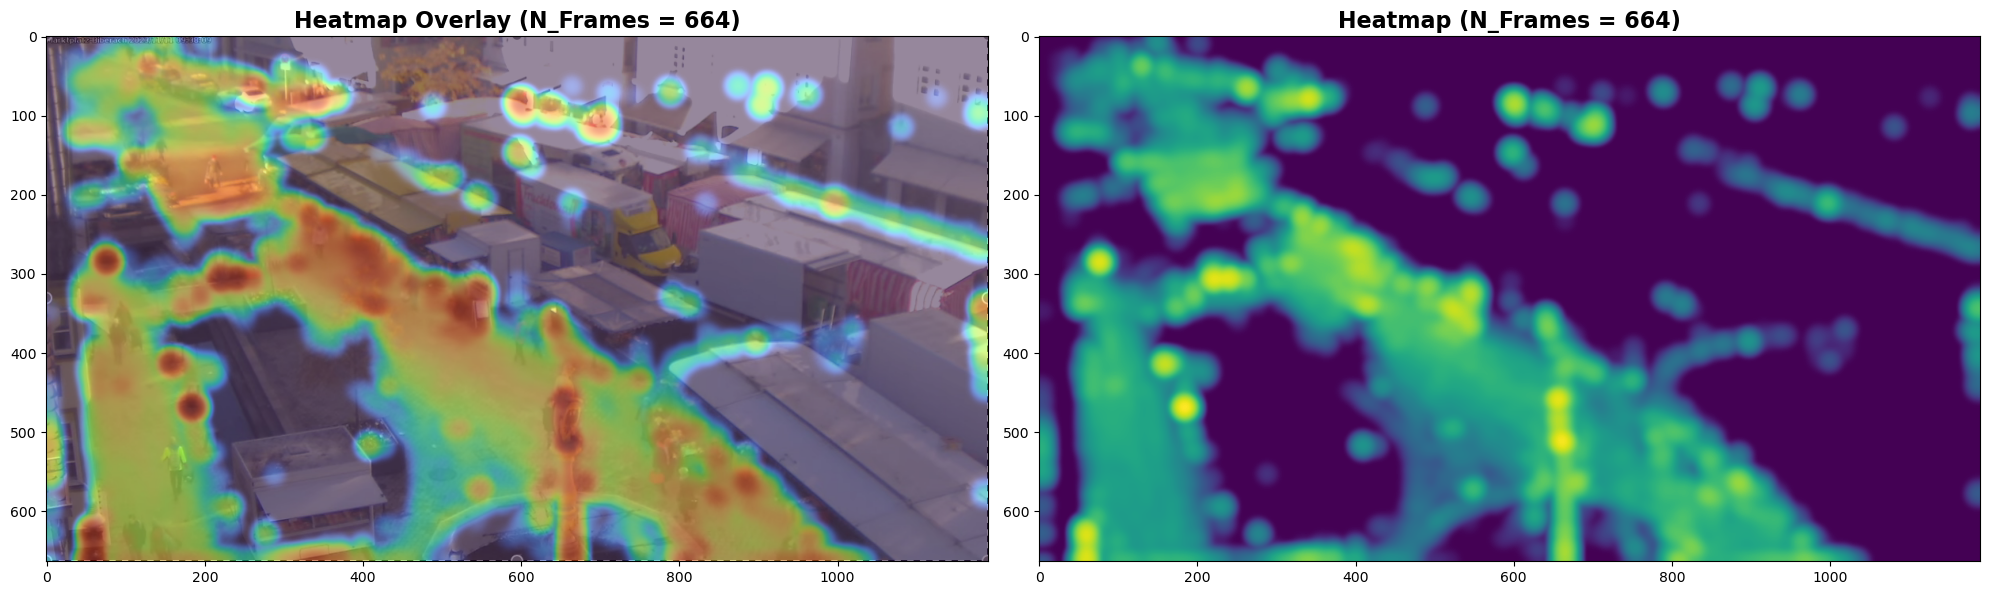

In [148]:
def plot_densities(img: np.array, densities: np.array) -> None:
    """ Plots the densities / heatmap as a two axis plot
    First axis shows the heatmap overlayed on the first input image;
    Second axis show the heatmap only.

    :param img: np.array -- Image with heatmap overlay (Result of cv2.addWeighted(image, heatmap))
    :param densities: np.array -- Image of heatmap
    :return: None
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
    axes[0].imshow(img)
    axes[0].set_title(f"Heatmap Overlay (N_Frames = {len(densities)})", size=16, fontweight="bold")
    axes[1].imshow(densities)
    axes[1].set_title(f"Heatmap (N_Frames = {len(densities)})", size=16, fontweight="bold")
    fig.tight_layout()
    plt.savefig('../assets/heatmap.png', dpi=350, bbox_inches='tight')
    plt.show()

plot_densities(img, densities)